# Introduction
> The aim of this competetion is to predict if a person after clicking a mobile app advertisement will download the app. The data is highly unbalanced with only 0.018% data of poistive class. 

The dataset is huge and highly unbalanced so undersampling the majority class seems to be a good option for modelling. 
For this notebook, I will be using full data for EDA.




## 1. Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
#CHANGE THIS
path = r'..\Data\Fraud'
import random

In [2]:
train = pd.read_csv(path+'\\train.csv')

In [3]:
test = pd.read_csv(path+'\\test.csv')

In [4]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [5]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


## 2. Field wise analysis

> This section contains analysis for each of the variable in the dataset. 

### 2.1 ip

* There are around 277K IPs in train set and around 94K in test
* We cannot affix an IP to a single person or an entity. Same IP can be owned by different person at different points in time. So we cannot block a particular IP until and unless we are quite sure it is a fraudulent one.

Read more on: <a>https://www.quora.com/Does-an-IP-address-of-a-computer-changes-every-time-you-login-in-to-the-internet</a>

####  % Intersection

In [6]:
ip_train = set(train.ip)
ip_test = set(test.ip)
print('Number of distinct IPs in train: ',len(ip_train))
print('Number of distinct IPs in test: ',len(ip_test))
print('% IPs in test that are in train as well: ',round(len([i for i in ip_test if i in ip_train])*100/len(ip_test),2))
print('% IPs in train that are in test as well: ',round(len([i for i in ip_train if i in ip_test])*100/len(ip_train),2))

Number of distinct IPs in train:  277396
Number of distinct IPs in test:  93936
% IPs in test that are in train as well:  40.63
% IPs in train that are in test as well:  13.76


> So, there are 40% of test IPs present in train and only 13% of train IPs in test.

#### Top Attributing IPs by %

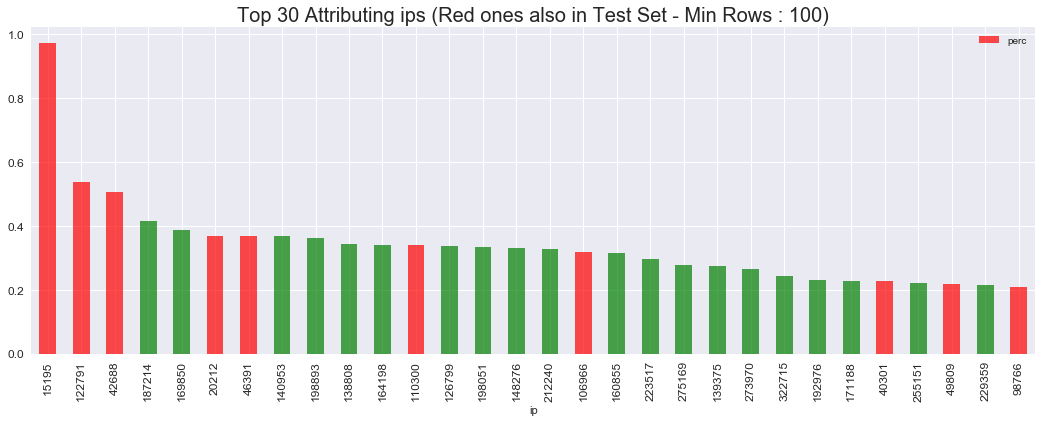

In [7]:
df=train[['ip','is_attributed']].groupby('ip').agg(['sum','mean','count'])
df = df.is_attributed.reset_index()
df['perc'] = df['sum']/df['count']
df['intest'] = df.ip.apply(lambda x: 1 if x in ip_test else 0) # If ip in test
# ips with high% attribution when no. of rows>100
df_reduced = df[df['count']>100].sort_values(by='perc',ascending=False)
color = df_reduced.head(30).apply(lambda x: 'red' if x.ip in ip_test else 'green',axis=1).values # red if present in test
_=df_reduced.head(30).plot(x='ip',y='perc',alpha=.7,kind='bar',figsize=(18,6),fontsize=12,color=[color]).set_title('Top 30 Attributing ips (Red ones also in Test Set - Min Rows : 100)',fontsize=20)

> For IPs with minimum 100 rows, 15195 have the highest conversion ratios. It drops smoothly for other IPs

#### Train vs Test Frequency distribution

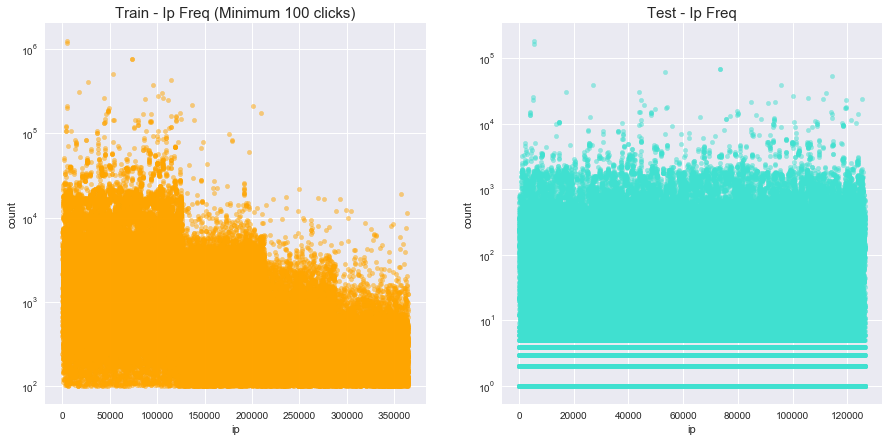

In [8]:
# test IP freq
df1 = test[['ip','click_id']].groupby('ip').count().reset_index()
df1.columns=['ip','count']
_=fig, axs = plt.subplots(1,2,figsize=(15,7))
_=df_reduced.plot(x='ip',y='count',alpha=.5,color='orange',ax=axs[0],kind='scatter',logy=True).set_title('Train - Ip Freq (Minimum 100 clicks)',fontsize=15)
_=df1.plot(x='ip',y='count',alpha=.5,color='turquoise',ax=axs[1],kind='scatter',logy=True).set_title('Test - Ip Freq',fontsize=15)

> 
* Note that the charts are in log scale (y-axis only). Also train data has been reduced for minimum of 100 clicks per IP
* There seems to be a clear staircase pattern in training IP frequencies. Test distibution does not have any visible staircase pattern. This is because the range of IPs in test is around 120000 that comes within the first staircase of train set. Don't know if this would have a negative effect if we include both IP frequency and IP in our model due to their correlation train and not in test.

Let's check their correlation matrix as well

In [9]:
print('Train:\n',df[['ip','count']].corr()) # Full data
print('\nTest:\n',df1[['ip','count']].corr())

Train:
           ip  count
ip     1.000 -0.174
count -0.174  1.000

Test:
           ip  count
ip     1.000 -0.000
count -0.000  1.000


> There is indeed a correlation between ip and frequency in Train but not in test

### 2.2 app

#### % Intersection

In [10]:
app_train = set(train.app)
app_test = set(test.app)
print('Number of distinct Apps in train: ',len(app_train))
print('Number of distinct Apps in test: ',len(app_test))
print('% Apps in test that are in train as well: ',round(len([i for i in app_test if i in app_train])*100/len(app_test),2))
print('% Apps in train that are in test as well: ',round(len([i for i in app_train if i in app_test])*100/len(app_train),2))

Number of distinct Apps in train:  706
Number of distinct Apps in test:  417
% Apps in test that are in train as well:  94.24
% Apps in train that are in test as well:  55.67


> Most of test apps are present in train

#### Top Attributing Apps by %

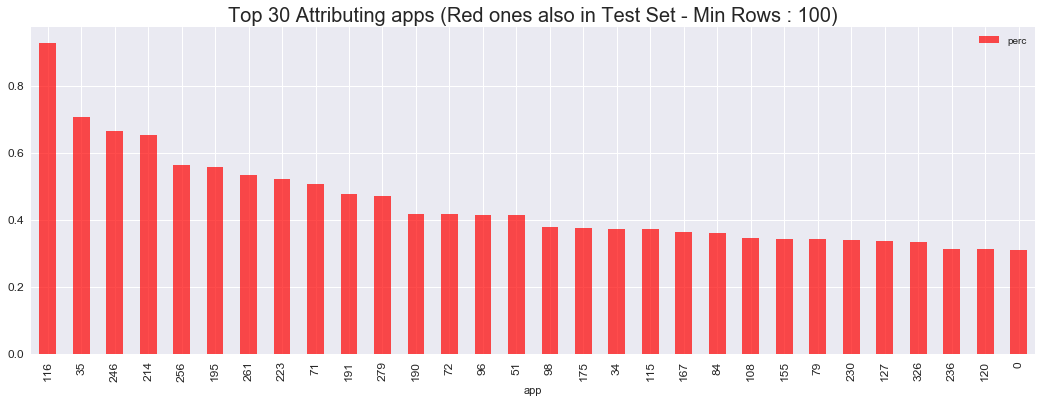

In [11]:
df=train[['app','is_attributed']].groupby('app').agg(['sum','mean','count'])
df = df.is_attributed.reset_index()
df['perc'] = df['sum']/df['count']
df['intest'] = df.app.apply(lambda x: 1 if x in app_test else 0) # If app in test
# apps with high% attribution when no. of rows>100
df_reduced = df[df['count']>100].sort_values(by='perc',ascending=False)
color = df_reduced.head(30).apply(lambda x: 'red' if x.app in app_test else 'green',axis=1).values # red if present in test
_=df_reduced.head(30).plot(x='app',y='perc',alpha=.7,kind='bar',figsize=(18,6),fontsize=12,color=[color]).set_title('Top 30 Attributing apps (Red ones also in Test Set - Min Rows : 100)',fontsize=20)

#### Train vs Test Frequency distribution

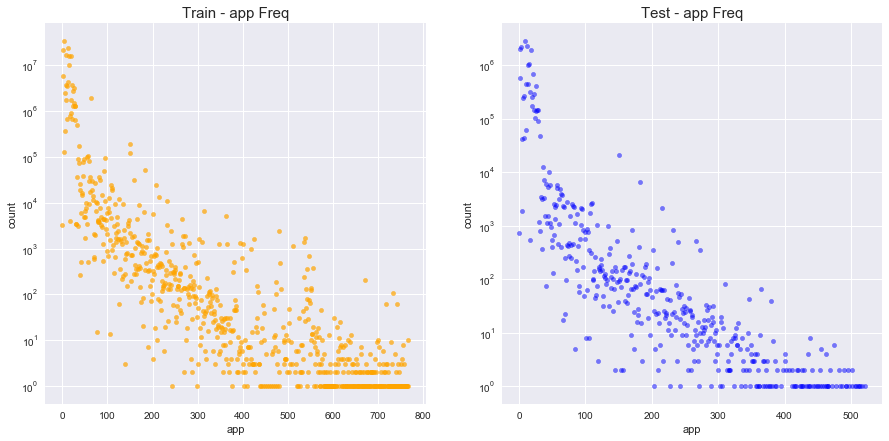

In [12]:
# test app freq
df1 = test[['app','click_id']].groupby('app').count().reset_index()
df1.columns=['app','count']

_=fig, axs = plt.subplots(1,2,figsize=(15,7))
_=df.plot(x='app',y='count',alpha=.7,color='orange',ax=axs[0],kind='scatter',logy=True).set_title('Train - app Freq',fontsize=15)
_=df1.plot(x='app',y='count',alpha=.5,color='blue',ax=axs[1],kind='scatter',logy=True).set_title('Test - app Freq',fontsize=15)


> 
* In both sets, number of clicks fall with increasing app no. Apps with low serial numbers are more popular.


### 2.3 Device

In [13]:
device_train = set(train.device)
device_test = set(test.device)
print('Number of distinct devices in train: ',len(device_train))
print('Number of distinct devices in test: ',len(device_test))
print('% device in test that are in train as well: ',round(len([i for i in device_test if i in device_train])*100/len(device_test),2))
print('% device in train that are in test as well: ',round(len([i for i in device_train if i in device_test])*100/len(device_train),2))

Number of distinct devices in train:  3475
Number of distinct devices in test:  1985
% device in test that are in train as well:  83.68
% device in train that are in test as well:  47.8


#### Top Attributing devices by %

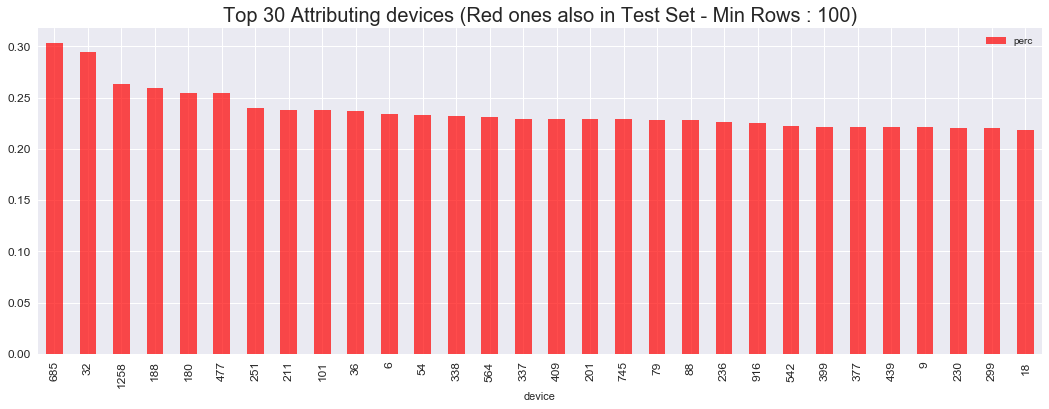

In [14]:
df=train[['device','is_attributed']].groupby('device').agg(['sum','mean','count'])
df = df.is_attributed.reset_index()
df['perc'] = df['sum']/df['count']
df['intest'] = df.device.apply(lambda x: 1 if x in device_test else 0) # If device in test
# devices with high% attribution when no. of rows>100
df_reduced = df[df['count']>100].sort_values(by='perc',ascending=False)
color = df_reduced.head(30).apply(lambda x: 'red' if x.device in device_test else 'green',axis=1).values # red if present in test
_=df_reduced.head(30).plot(x='device',y='perc',alpha=.7,kind='bar',figsize=(18,6),fontsize=12,color=[color]).set_title('Top 30 Attributing devices (Red ones also in Test Set - Min Rows : 100)',fontsize=20)

#### Train vs Test Frequency distribution

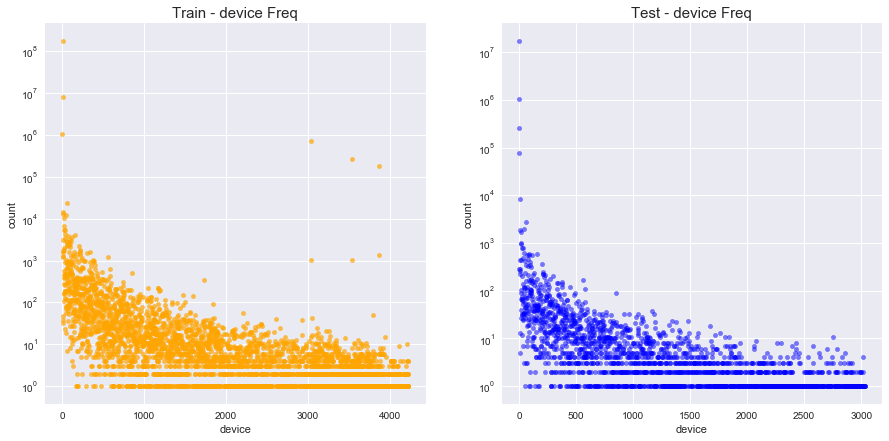

In [15]:
# test device freq
df1 = test[['device','click_id']].groupby('device').count().reset_index()
df1.columns=['device','count']
_=fig, axs = plt.subplots(1,2,figsize=(15,7))
_=df.plot(x='device',y='count',alpha=.7,color='orange',ax=axs[0],kind='scatter',logy=True).set_title('Train - device Freq',fontsize=15)
_=df1.plot(x='device',y='count',alpha=.5,color='blue',ax=axs[1],kind='scatter',logy=True).set_title('Test - device Freq',fontsize=15)


> 
* Again, lower ids have more clicks. Some devices with lowest ids have sky-high frequencies. These may belong to the most selling brands in china.
Note: <a>https://www.statista.com/statistics/430749/china-smartphone-shipments-vendor-market-share/</a>
* Train set and test have same distribution
* There are some outliers with >3000 ids in train. 

### 2.4 OS

In [16]:
os_train = set(train.os)
os_test = set(test.os)
print('Number of distinct os in train: ',len(os_train))
print('Number of distinct os in test: ',len(os_test))
print('% os in test that are in train as well: ',round(len([i for i in os_test if i in os_train])*100/len(os_test),2))
print('% os in train that are in test as well: ',round(len([i for i in os_train if i in os_test])*100/len(os_train),2))

Number of distinct os in train:  800
Number of distinct os in test:  395
% os in test that are in train as well:  85.82
% os in train that are in test as well:  42.38


#### Top Attributing devices by %

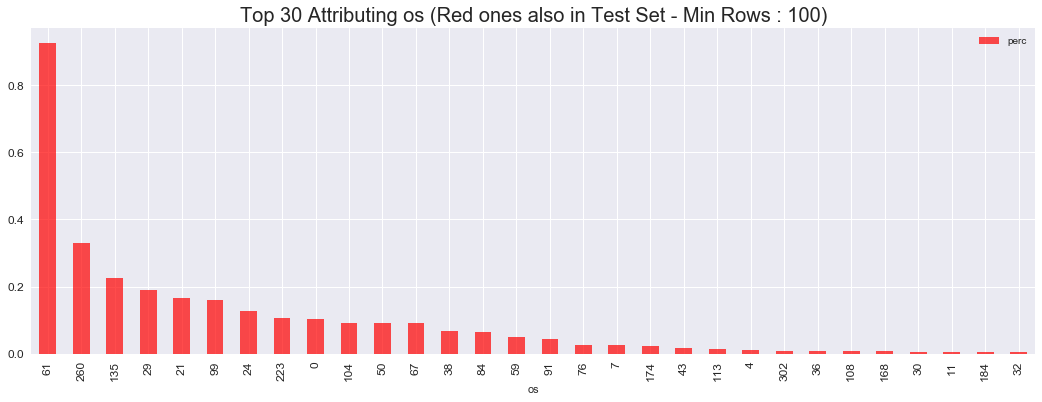

In [17]:
df=train[['os','is_attributed']].groupby('os').agg(['sum','mean','count'])
df = df.is_attributed.reset_index()
df['perc'] = df['sum']/df['count']
df['intest'] = df.os.apply(lambda x: 1 if x in os_test else 0) # If os in test
# oss with high% attribution when no. of rows>100
df_reduced = df[df['count']>100].sort_values(by='perc',ascending=False)
color = df_reduced.head(30).apply(lambda x: 'red' if x.os in os_test else 'green',axis=1).values # red if present in test
_=df_reduced.head(30).plot(x='os',y='perc',alpha=.7,kind='bar',figsize=(18,6),fontsize=12,color=[color]).set_title('Top 30 Attributing os (Red ones also in Test Set - Min Rows : 100)',fontsize=20)

#### Train vs Test frequency distribution

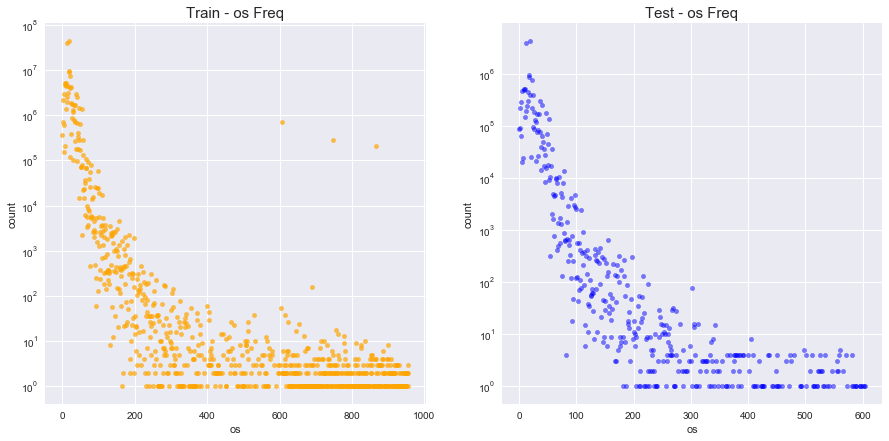

In [18]:
# test os freq
df1 = test[['os','click_id']].groupby('os').count().reset_index()
df1.columns=['os','count']
_=fig, axs = plt.subplots(1,2,figsize=(15,7))
_=df.plot(x='os',y='count',alpha=.7,color='orange',ax=axs[0],kind='scatter',logy=True).set_title('Train - os Freq',fontsize=15)
_=df1.plot(x='os',y='count',alpha=.5,color='blue',ax=axs[1],kind='scatter',logy=True).set_title('Test - os Freq',fontsize=15)


### 2.5 Channel

In [19]:
channel_train = set(train.channel)
channel_test = set(test.channel)
print('Number of distinct channel in train: ',len(channel_train))
print('Number of distinct channel in test: ',len(channel_test))
print('% channel in test that are in train as well: ',round(len([i for i in channel_test if i in channel_train])*100/len(channel_test),2))
print('% channel in train that are in test as well: ',round(len([i for i in channel_train if i in channel_test])*100/len(channel_train),2))

Number of distinct channel in train:  202
Number of distinct channel in test:  178
% channel in test that are in train as well:  100.0
% channel in train that are in test as well:  88.12


#### Top Attributing devices by %

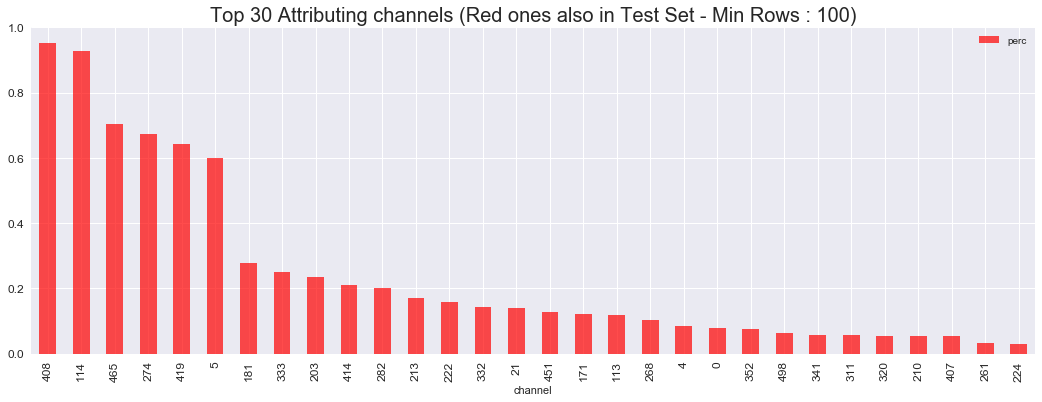

In [20]:
df=train[['channel','is_attributed']].groupby('channel').agg(['sum','mean','count'])
df = df.is_attributed.reset_index()
df['perc'] = df['sum']/df['count']
df['intest'] = df.channel.apply(lambda x: 1 if x in channel_test else 0) # If channel in test
# channels with high% attribution when no. of rows>100
df_reduced = df[df['count']>100].sort_values(by='perc',ascending=False)
color = df_reduced.head(30).apply(lambda x: 'red' if x.channel in channel_test else 'green',axis=1).values # red if present in test
_=df_reduced.head(30).plot(x='channel',y='perc',alpha=.7,kind='bar',figsize=(18,6),fontsize=12,color=[color]).set_title('Top 30 Attributing channels (Red ones also in Test Set - Min Rows : 100)',fontsize=20)	

#### Train vs Test frequency distribution

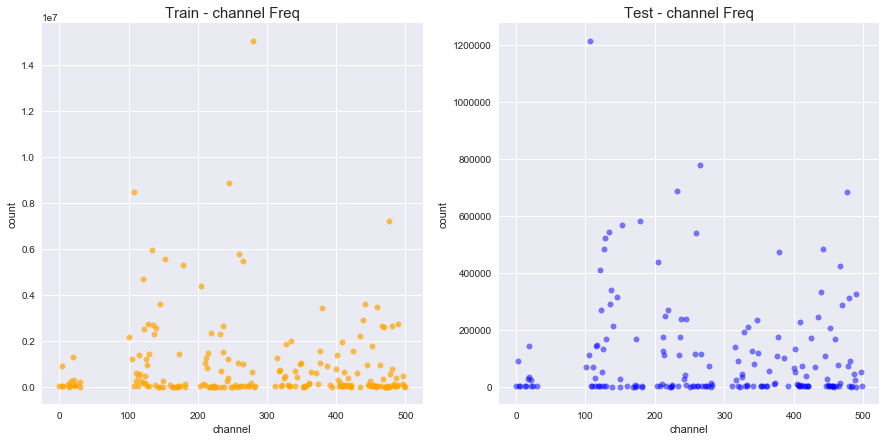

In [21]:
# test channel freq
df1 = test[['channel','click_id']].groupby('channel').count().reset_index()
df1.columns=['channel','count']
_=fig, axs = plt.subplots(1,2,figsize=(15,7))
_=df.plot(x='channel',y='count',alpha=.7,color='orange',ax=axs[0],kind='scatter',s=30).set_title('Train - channel Freq',fontsize=15)
_=df1.plot(x='channel',y='count',alpha=.5,color='blue',ax=axs[1],kind='scatter',s=30).set_title('Test - channel Freq',fontsize=15)


* Channel does not follow any pattern unlike app,os and device.

In [22]:
del df,df1,df_reduced

### 2.6 Click Time
Its time to explore the click time. 

In [23]:
#Define function to create date features
def time_feat(df):
    df['click_time']=pd.to_datetime(df.click_time)
    df['click_day']=df.click_time.dt.day
    df['click_hour']=df.click_time.dt.hour
    df['click_minute']=df.click_time.dt.minute
    df['click_second']=df.click_time.dt.second
    return df

In [24]:
#Create date features
train = time_feat(train)
test = time_feat(test)

### 2.6.1 Click Time - Days
Lets first check the days present in training and test set

In [25]:
print('Days in Train:',set(train.click_day),'\nDays in Test:',set(test.click_day))

Days in Train: {8, 9, 6, 7} 
Days in Test: {10}


> Data in train set has been collected for 4 consecutive days : 6,7,8 and 9. Test set comes from the 10th day.

#### Avg Downloads and No. of clicks per day

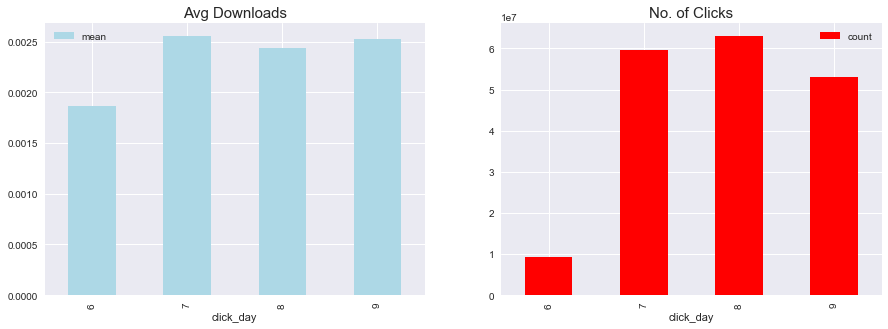

In [26]:
df=train[['click_day','is_attributed']].groupby('click_day').agg(['mean','count'])
df = df.is_attributed.reset_index()
fig, (axs) = plt.subplots(1,2,figsize=(15,5))
_=df.plot(x='click_day',y='mean',kind='bar',ax=axs[0],color='lightblue').set_title('Avg Downloads',fontsize=15)
_=df.plot(x='click_day',y='count',kind='bar',ax=axs[1],color='red').set_title('No. of Clicks',fontsize=15)

> For the day 6, the number of click are very low. This doesn't seem right. Lets check no. of hours in each day for which we have the data.

### 2.6.2 Hour

Lets first check the number of hours in each day in both the sets

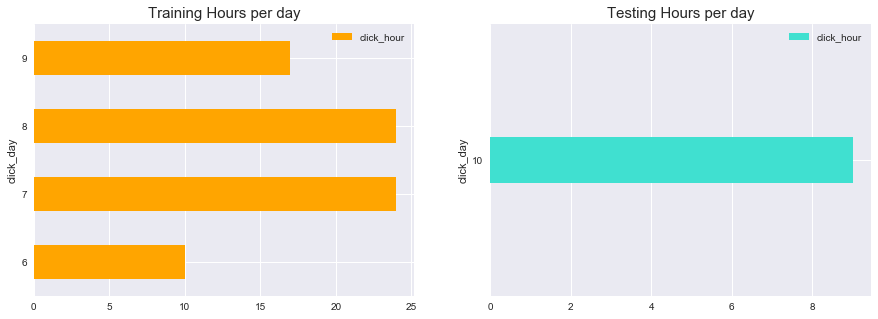

In [27]:
# Check for partial day data
fig, (axs) = plt.subplots(1,2,figsize=(15,5))
df_day_hr=train[['click_day','click_hour']].drop_duplicates()
df_day_hr.groupby('click_day').count().plot(kind='barh',color='orange',title='Training Hours per day',ax=axs[0])
df1_day_hr=test[['click_day','click_hour']].drop_duplicates()
df1_day_hr.groupby('click_day').count().plot(kind='barh',color='turquoise',title='Testing Hours per day',ax=axs[1],width=0.1)
axs[0].title.set_size(15)
axs[1].title.set_size(15)

> 
* We have partial data for days 6 and 9 in training data. 
* We have 24 hrs data for day 7 and 8
* In test set, we have data for 9 hrs

#### Avg Downloads and No. of clicks per hour
* Day 7 and 8 will be used as we have full day data for them

Text(0.5,1,'No. of Clicks')

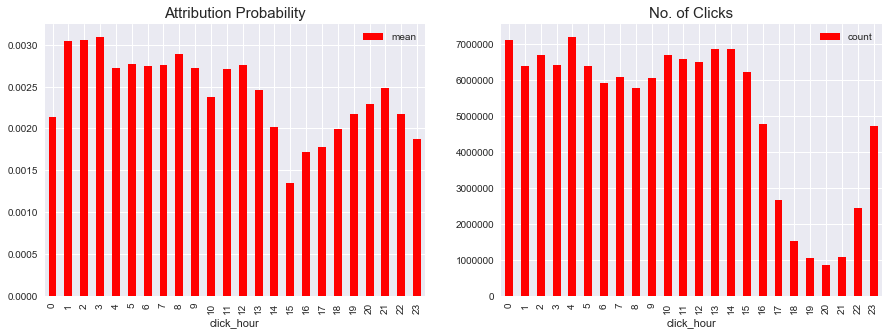

In [28]:
# Plot data for full hour days only
df=train[['click_hour','is_attributed']][(train.click_day==7)|(train.click_day==8)].groupby('click_hour').agg(['mean','count'])
df = df.is_attributed.reset_index()
fig, (axs) = plt.subplots(1,2,figsize=(15,5))
df.plot(x='click_hour',y='mean',kind='bar',ax=axs[0],color='red').set_title('Attribution Probability',fontsize=15)
df.plot(x='click_hour',y='count',kind='bar',ax=axs[1],color='red').set_title('No. of Clicks',fontsize=15)

> 
* Attribution probability decreases from 11 AM to 3PM and again rises till 9PM after which it falls till midnight. Night hours seem to be high on attributions
* There is a significant drop in click after 3 PM to 9PM. These hours have opposite trends in Attribution and No of clicks

### 2.7 IP and Click Time

To maximize the money made by clicking, fraudsters may use bots to click as many advertisements as they can in short amount of time. Most of the time, these will be done using the same IP unless they use IP rotation softwares.
So we will check if we can differentiate between them by checking the time taken to make subsequent clicks from the same IP.

In [29]:
# Calculate time difference between subsequent clicks
train = train.sort_values(by=['ip','click_time']) # Too much time
train['previous_click_time']=train.click_time.shift(1)
train['click_time_diff'] = (train.click_time-train.previous_click_time)/np.timedelta64(1, 's')
train['click_time_diff']=train['click_time_diff'].fillna(-999)
#train.drop('click_time',axis=1,inplace=True)

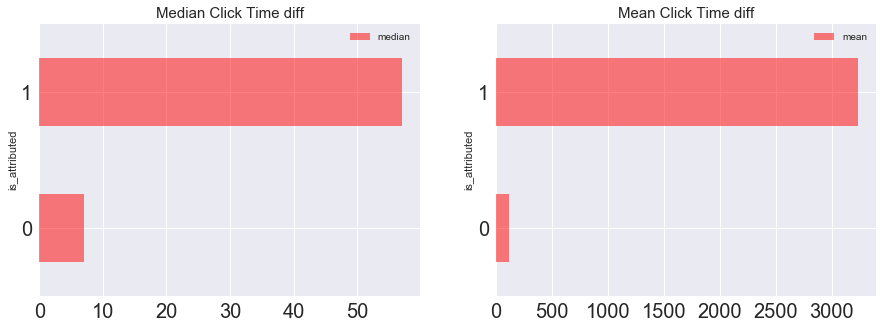

In [31]:
# Woh!
print('Median Time Diff between clicks for Download : ',train['click_time_diff'][(train.is_attributed==1) & (train.click_time_diff>0)].median())
print('Median Time Diff between clicks for No Download : ',train['click_time_diff'][(train.is_attributed==0) & (train.click_time_diff>0)].median())
print('Avg Time Diff between clicks for Download : ',train['click_time_diff'][(train.is_attributed==1) & (train.click_time_diff>0)].mean())
print('Avg Time Diff between clicks for No Download : ',train['click_time_diff'][(train.is_attributed==0) & (train.click_time_diff>0)].mean())

df = train[(train.click_time_diff>0)][['is_attributed','click_time_diff']].groupby('is_attributed').agg(['median','mean'])
df = df.click_time_diff.reset_index()
fig, (axs) = plt.subplots(1,2,figsize=(15,5))
_=df.plot(x='is_attributed',kind='barh',y='median',ax=axs[0],color='red',alpha=0.5,fontsize=20).set_title('Median Click Time diff',fontsize=15)
_=df.plot(x='is_attributed',kind='barh',y='mean',ax=axs[1],color='red',alpha=0.5,fontsize=20).set_title('Mean Click Time diff',fontsize=15)

* Please note: Removed around 53K (out of 456K) cases which were first time positive hits as for them there is no meaning of last click.
* There is a huge difference between the median/mean click time difference. Click time between subsequent clicks is much more for positive attributions.
* Because of this big difference, it can be an important feature to include in our models
* There can be som genuine cases where click time difference may be very low for positive attributions. 
* From feature engineering perspective, we can add more features like:
  
  * **If the previous click from same IP was on same app/device/os/channel or not**. This in combination of click time would weed out cases where an IP is switching apps/devices/os/channel in small amount of time.

Thats all for now. Will add more if it 'clicks' :D